In [1]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
Data = pd.read_csv('/content/sample_data/consumer_complaints.csv',encoding = 'latin1')
Data.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074.0
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080.0
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473.0
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326.0
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067.0


In [20]:
Data.dtypes

date_received                    object
product                          object
sub_product                      object
issue                            object
sub_issue                        object
consumer_complaint_narrative     object
company_public_response          object
company                          object
state                            object
zipcode                          object
tags                             object
consumer_consent_provided        object
submitted_via                    object
date_sent_to_company             object
company_response_to_consumer     object
timely_response                  object
consumer_disputed?               object
complaint_id                    float64
dtype: object

In [22]:
Data.describe(include="all")

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
count,210055,210055,151241,210055,100943,2337,3180,210054,208986,209361,30889,5017,210054,210054,210054,210054,210054,2.100540e+05
unique,560,11,46,92,68,2295,9,2641,62,20995,3,3,6,631,5,2,2,NaN
top,06/26/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",Debt is not mine,This company continues to report on my credit ...,Company chooses not to provide a public response,Bank of America,CA,76116,Older American,Consent not provided,Web,03/12/2014,Closed with explanation,Yes,No,NaN
freq,889,58447,20005,28790,14042,19,1893,14226,29496,317,17456,2497,146777,903,161580,204926,168473,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.485122e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.172313e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.099440e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.695862e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.514035e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.135887e+06


In [23]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210055 entries, 0 to 210054
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date_received                 210055 non-null  object 
 1   product                       210055 non-null  object 
 2   sub_product                   151241 non-null  object 
 3   issue                         210055 non-null  object 
 4   sub_issue                     100943 non-null  object 
 5   consumer_complaint_narrative  2337 non-null    object 
 6   company_public_response       3180 non-null    object 
 7   company                       210054 non-null  object 
 8   state                         208986 non-null  object 
 9   zipcode                       209361 non-null  object 
 10  tags                          30889 non-null   object 
 11  consumer_consent_provided     5017 non-null    object 
 12  submitted_via                 210054 non-nul

In [24]:
Data.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

In [25]:
Data.isna().sum()

date_received                        0
product                              0
sub_product                      58814
issue                                0
sub_issue                       109112
consumer_complaint_narrative    207718
company_public_response         206875
company                              1
state                             1069
zipcode                            694
tags                            179166
consumer_consent_provided       205038
submitted_via                        1
date_sent_to_company                 1
company_response_to_consumer         1
timely_response                      1
consumer_disputed?                   1
complaint_id                         1
dtype: int64

In [26]:
pd.notnull(Data['consumer_complaint_narrative']).value_counts()

False    207718
True       2337
Name: consumer_complaint_narrative, dtype: int64

In [27]:
# Exploratory Data Analysis

In [28]:
data = Data[['consumer_complaint_narrative','product']]
data = data.dropna()
data.head(1000)

,consumer_complaint_narrative,product
190126,XXXX has claimed I owe them {$27.00} for XXXX ...,Debt collection
190135,Due to inconsistencies in the amount owed that...,Consumer Loan
190155,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
190207,I have an open and current mortgage with Chase...,Mortgage
190208,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
...,...,...
203235,On my credit report XXXX is not reporting what...,Consumer Loan
203241,I have XXXX credit card accounts with capital ...,Credit card
203244,"Bank of America, which is my own bank, took my...",Bank account or service
203246,We received a tax abatement and our escrow pay...,Mortgage


In [29]:
data.dtypes

consumer_complaint_narrative    object
product                         object
dtype: object

In [30]:
data['product'].value_counts()

Debt collection            638
Mortgage                   588
Credit reporting           361
Credit card                265
Bank account or service    174
Consumer Loan              125
Student loan               105
Payday loan                 36
Money transfers             28
Prepaid card                14
Other financial service      3
Name: product, dtype: int64

In [31]:
data['product'].loc[(data['product'] == "Credit reporting") | (data['product'] == "Credit reporting, credit repair services, or other personal consumer reports") | 
         (data['product'] == "Credit card") | (data['product'] == "Credit card or prepaid card") | (data['product'] == "Prepaid card")] = "Credit Card Related"

data['product'].loc[(data['product'] == "Student loan") | (data['product'] == "Consumer Loan") | 
         (data['product'] == "Vehicle loan or lease") | (data['product'] == "Payday loan") | (data['product'] == "Payday loan, title loan, or personal loan")] = "Loan Related"

data['product'].loc[(data['product'] == "Bank account or service") | (data['product'] == "Checking or savings account") | 
         (data['product'] == "Money transfer, virtual currency, or money service") | (data['product'] == "Money transfers")] = "Bank Services"

data['product'].loc[(data['product'] == "Debt collection") | (data['product'] == "Mortgage") | 
         (data['product'] == "Virtual currency") | (data['product'] == "Other financial service") | (data['product'] == "Prepaid card")] = "Others Services"

data.reset_index(inplace = True)
data.drop('index',axis='columns', inplace=True)

In [32]:
data['product'].value_counts()

Others Services        1229
Credit Card Related     640
Loan Related            266
Bank Services           202
Name: product, dtype: int64

In [33]:
data.head()

,consumer_complaint_narrative,product
0,XXXX has claimed I owe them {$27.00} for XXXX ...,Others Services
1,Due to inconsistencies in the amount owed that...,Loan Related
2,In XX/XX/XXXX my wages that I earned at my job...,Others Services
3,I have an open and current mortgage with Chase...,Others Services
4,XXXX was submitted XX/XX/XXXX. At the time I s...,Others Services


In [34]:
def example_complain(index):
    example = data[data.index == index][['consumer_complaint_narrative', 'product']].values[0]
    if len(example) > 0:
        print(example[0])
        print()
        print('Category:', example[1])

In [35]:
example_complain(10)

I am very disappointed that the CFPB did not help to resolve this fraudulant loan. # XXXX between XXXX XXXX and XXXX, FF ( AKA ) One West. Case # XXXX with CFPB. 


Category: Others Services


In [36]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(clean_text)

In [37]:
example_complain(10)

disappointed cfpb help resolve fraudulant loan # ff aka one west case # cfpb

Category: Others Services


In [38]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11398 unique tokens.


In [39]:
# Train-Test Split

In [40]:
X = tokenizer.texts_to_sequences(data['consumer_complaint_narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2337, 250)


In [41]:
Y = pd.get_dummies(data['product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2337, 4)


In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1869, 250) (1869, 4)
(468, 250) (468, 4)


In [66]:
# Model Building

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
epochs = 5
batch_size = 100

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3,verbose=2, mode='auto',)])

Epoch 1/5
17/17 [==============================] - 19s 970ms/step - loss: 1.2818 - accuracy: 0.4917 - val_loss: 1.1284 - val_accuracy: 0.5615
Epoch 2/5
17/17 [==============================] - 16s 948ms/step - loss: 1.1007 - accuracy: 0.5202 - val_loss: 1.0590 - val_accuracy: 0.5615
Epoch 3/5
17/17 [==============================] - 16s 951ms/step - loss: 0.9217 - accuracy: 0.5933 - val_loss: 1.0549 - val_accuracy: 0.5241
Epoch 4/5
17/17 [==============================] - 16s 952ms/step - loss: 0.7759 - accuracy: 0.7134 - val_loss: 0.9415 - val_accuracy: 0.6364
Epoch 5/5
17/17 [==============================] - 16s 954ms/step - loss: 0.5340 - accuracy: 0.7830 - val_loss: 0.9058 - val_accuracy: 0.6684


In [59]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

15/15 [==============================] - 1s 68ms/step - loss: 0.7719 - accuracy: 0.7436
Test set
  Loss: 0.772
  Accuracy: 0.744


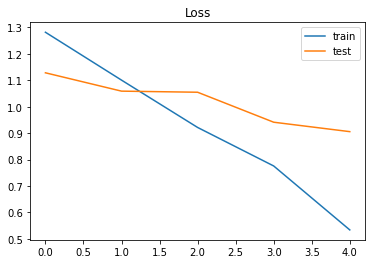

In [68]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

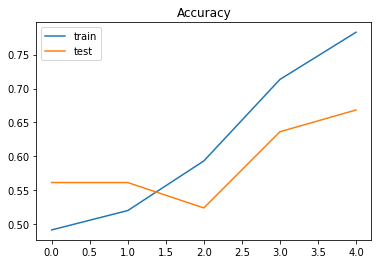

In [69]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [76]:
new_complaint = ['This letter is to dispute an incorrectly charged amount on my credit card']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[0.14037882 0.5841123  0.12789293 0.14761586]] Debt collection
